# Data Acquisition

In [52]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import tree, preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from itertools import chain, combinations
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_decision_regions
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree

In [53]:
url = "https://philchodrow.github.io/PIC16A/datasets/palmer_penguins.csv"
data = pd.read_csv(url)
data.head(5)

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,11/11/07,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.
1,PAL0708,2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,11/11/07,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
2,PAL0708,3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,11/16/07,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN
3,PAL0708,4,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A2,Yes,11/16/07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.
4,PAL0708,5,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,11/16/07,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN


The penguins dataset encodes information about penguins. The dataset includes 344 subjects, and records information on their study name, sample number, species, region, island, ID, whether they have completed clutch, their culmen length, flipper length and culmen depth in millermeter, body mass in grams, sex, Delta 15 N, Delta 13 C, and comments summarizing their physical examination.

### Preprocess data

In [54]:
def sample_penguins(penguins):
    """
    preprocess penguins dataset
    """
    penguins2 = penguins.copy()
    
    #shorten species name to its first word
    penguins2["Species"] = penguins["Species"].str.split().str.get(0)

    #reduce dataframe to relevant columns
    penguins2 = penguins2[["Sample Number", "Species","Island","Culmen Length (mm)", 
                         "Culmen Depth (mm)", "Flipper Length (mm)",
                         "Body Mass (g)","Sex", "Delta 15 N (o/oo)",
                         "Delta 13 C (o/oo)"]]

    #drop data wtih NaN values 
    penguins2 = penguins2.dropna()

    #drop data with wrongly recorded "Sex"
    penguins2 = penguins2[penguins2["Sex"] != "."]
    
    #label encoders
    le = preprocessing.LabelEncoder()
    keys = []
    for column in ["Sex", "Species", "Island"]:
        penguins2[column] = le.fit_transform(penguins2[column])
        keys.append(dict(zip(le.transform(le.classes_),le.classes_, )))
    

    #split into X and y sets
    X=penguins2.drop(["Species"],axis=1)        
    y=penguins2["Species"]
    
    #further split into train and test sets
    X_train,X_test ,y_train, y_test=train_test_split(X,y,test_size=.2)
 
    return penguins2, X_train, X_test, y_train, y_test, keys

penguins, X_train, X_test, y_train, y_test, keys = sample_penguins(data)

We preprocess the penguins data to prepare for the modeling afterward, we code the qualitative characters with numbers for easier handling, and selected the species column to be our y axis. We also separated all the subjects we have into training data and testing data with a ratio of 4:1.

# Exploratory Analysis


## Number of each species on each island

In [17]:
#shorten species name to first word
data["Species"] = data["Species"].str.split().str.get(0)

<AxesSubplot:xlabel='Island', ylabel='Count'>

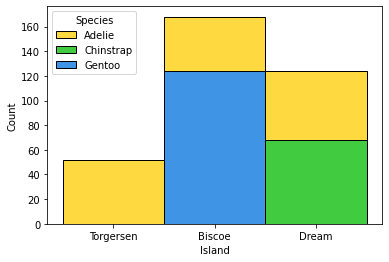

In [18]:
sns.histplot(data=data, x="Island", 
             hue="Species", 
             multiple="stack", 
             palette = "nipy_spectral_r")

Adelie penguins can be found on all three islands, but Torgensen only has Adelie penguins. Thus, if we are given a new penguin whose island is Torgensen, we can safely predict that its species is Adelie.

If we are given a new penguin whose island is Biscoe, we can rule out Chinstrap.

If we are given a new penguin whose island is Dream, we can rule out Gentoo.

Thus, island is a good predictor variable to use as there are immediately clear cut distinctions between the penguin species.

## Culmen Length, Culmen Depth, Flipper Length and Body Mass

In [19]:
def penguin_summary_table(group_cols, value_cols):
    return data.groupby(group_cols)[value_cols].mean().round(2)

penguin_summary_table(["Species"], ["Culmen Length (mm)", "Culmen Depth (mm)", "Body Mass (g)"])


,Culmen Length (mm),Culmen Depth (mm),Body Mass (g)
Species,,,
Adelie,38.79,18.35,3700.66
Chinstrap,48.83,18.42,3733.09
Gentoo,47.50,14.98,5076.02


Adelie penguins have much smaller culmen length and gentoo penguins have much smaller culmen depth and body mass. All three variables can possibly be used for prediction. 

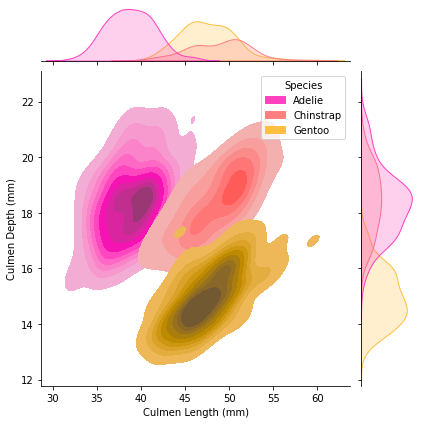

In [20]:
sns.jointplot(data = data, x = "Culmen Length (mm)", 
              y = "Culmen Depth (mm)", 
              hue = "Species", palette = "spring", 
              kind = "kde", fill = True)

Penguins with a smaller Culmen Length are more likely to be Adelie penguins than they are to be Chinstrap or Gentoo penguins.

Penguins with an smaller Culmen Depth are more likely to be Gentoo penguins than they are to be Adelie or Chinstrap penguins.

From the above summary table and plot, we can see that Culmen Length and Culmen Depth are good predictor variables to use as they can immediately help us distinguish between the penguin species. 

<AxesSubplot:xlabel='Flipper Length (mm)', ylabel='Body Mass (g)'>

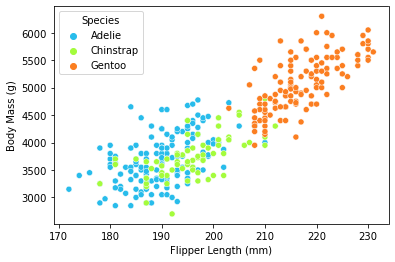

In [35]:
sns.scatterplot(data = data, 
                x = "Flipper Length (mm)", 
                y = "Body Mass (g)", 
                hue = "Species", 
                palette = "turbo")

Gentoo penguins have much larger flipper length and body mass than the other two species of penguins. Flipper length is also a possible predictor variable.

## Delta 13 C (o/oo) and Delta 15 N (o/oo)

<AxesSubplot:xlabel='Species', ylabel='Delta 13 C (o/oo)'>

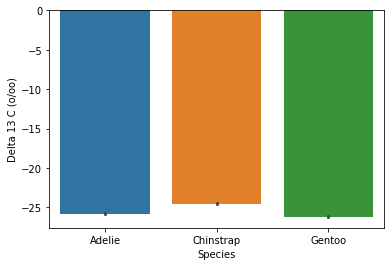

In [22]:
sns.barplot(data = data, x = "Species", y = "Delta 13 C (o/oo)")

<AxesSubplot:xlabel='Species', ylabel='Delta 15 N (o/oo)'>

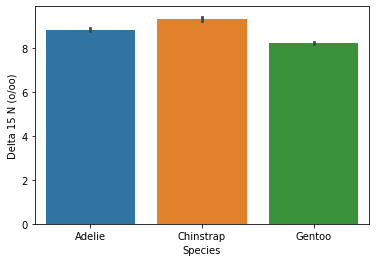

In [23]:
sns.barplot(data = data, x = "Species", y = "Delta 15 N (o/oo)")

The average Delta 13C (o/oo) and Delta 15N (o/oo) for each species is quite similar. Hence, it would be hard to differentiate a penguin's species by its Delta 13C (o/oo) and Delta 15N (o/oo). Hence, we will likely not be using these two variables as predictor variables in our models. 

# Modeling

# Multinomial Logistic Regression

### Feature Selection

In [24]:
LR = LogisticRegression(solver="liblinear")
shuffle(X_train, y_train)

subsets_cols = [i for i in combinations(X_train.columns, 3)]#creating a list of all possible 3 member combinations 

In [25]:
results = []
for active in subsets_cols:
    #compute their cross validation score
    CV_score = cross_val_score(LR, X_train[list(active)], y_train, cv=7).mean()
    #store their performance into a list
    results.append((active, CV_score))
    
#organize the elements of the list by decending order of their performance
results.sort(key=(lambda tup: tup[1]), reverse = True)
results = pd.DataFrame(results, columns=["Columns", "CV_score"])

#print out our results to find the best combination of traits 
results.head(5)

,Columns,CV_score
0,"(Culmen Length (mm), Culmen Depth (mm), Body M...",0.988417
1,"(Culmen Length (mm), Culmen Depth (mm), Flippe...",0.984556
2,"(Culmen Length (mm), Culmen Depth (mm), Delta ...",0.976834
3,"(Culmen Length (mm), Flipper Length (mm), Delt...",0.965251
4,"(Island, Culmen Length (mm), Culmen Depth (mm))",0.961390


We will hence choose the columns Island, Culmen Length (mm), Culmen Depth (mm) which has a cross validation score of 0.961390.

### Estimate optimal model complexity

In [26]:
X_train0 = X_train[["Culmen Length (mm)", "Culmen Depth (mm)","Island"]]
X_test0 = X_test[["Culmen Length (mm)", "Culmen Depth (mm)","Island"]]

In [27]:
#select the best parameter for the model 
best_score=-np.inf
C_pool=np.linspace(.005,.1,50)
scores=np.zeros((4,len(C_pool)))

for cv0 in range(2,6):#loop through all the CV values 
    for c in range(len(C_pool)):#loop through all possible c values 
        LR = LogisticRegression(solver="liblinear", C = C_pool[c])
        scores[cv0-2, c]=cross_val_score(LR,X_train0,y_train,cv=cv0).mean()
        if scores[cv0-2, c]>best_score:#compute the best socres and the best pair of parameters
            best_C= C_pool[c]
            best_score=scores[cv0-2, c]
            best_cv = cv0
      
print("Optimal CV: " + str(best_cv))
print("Optimal C: " + str(best_C))
print("Cross Validation Score: " + str(best_score))


Optimal CV: 4
Optimal C: 0.09612244897959184
Cross Validation Score: 0.91875


[Text(0.5, 1.0, 'CV: 4'),
 Text(0.5, 0, 'inverse regularization strength'),
 Text(0, 0.5, 'CV Score')]

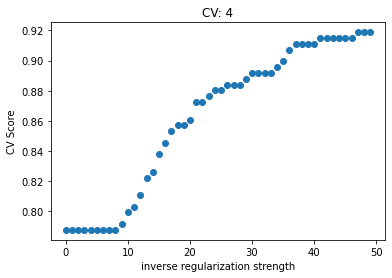

In [28]:
fig,ax=plt.subplots(1)

ax.scatter(range(len(C_pool)),scores[best_cv-2,:])
ax.set(title="CV: "+str(best_cv), 
       xlabel = "inverse regularization strength", 
       ylabel = "CV Score")

We thus conclude that CV=4, C=0.096 is the best possible pair of parameters for our logistics regression model, which yields a best cross validation score of 0.91875.

### Evaluating model performance on test sets

In [29]:
LR = LogisticRegression(solver="liblinear", C = best_C)
LR.fit(X_train0, y_train)

print("Logistic regression score: " + str(LR.score(X_test0, y_test)))

Logistic regression score: 0.9230769230769231


[[116   0   0]
 [ 10  39   6]
 [  0   0  88]]


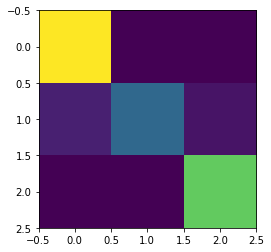

In [30]:
y_train_pred = LR.predict(X_train0)
c = confusion_matrix(y_train, y_train_pred)
print(c)
plt.imshow(c)

In [31]:
#To see the individual misclassified penguins
mistakes = X_train[y_train != y_train_pred]
mistakes = np.asarray(mistakes["Sample Number"])
mistake_labels = np.asarray(y_train[y_train != y_train_pred])
mistake_preds = y_train_pred[y_train != y_train_pred]

In [32]:
for i in range(len(mistake_labels)):
    print("Predicted: " + str(keys[1][mistake_preds[i]]) + ", True: " + str(keys[1][mistake_labels[i]])
         + ", Sample number: " + str(mistakes[i]))

Predicted: Gentoo, True: Chinstrap, Sample number: 14
Predicted: Adelie, True: Chinstrap, Sample number: 9
Predicted: Gentoo, True: Chinstrap, Sample number: 51
Predicted: Gentoo, True: Chinstrap, Sample number: 45
Predicted: Adelie, True: Chinstrap, Sample number: 21
Predicted: Adelie, True: Chinstrap, Sample number: 31
Predicted: Adelie, True: Chinstrap, Sample number: 17
Predicted: Adelie, True: Chinstrap, Sample number: 4
Predicted: Adelie, True: Chinstrap, Sample number: 58
Predicted: Adelie, True: Chinstrap, Sample number: 55
Predicted: Adelie, True: Chinstrap, Sample number: 60
Predicted: Adelie, True: Chinstrap, Sample number: 65
Predicted: Adelie, True: Chinstrap, Sample number: 19
Predicted: Gentoo, True: Chinstrap, Sample number: 50
Predicted: Gentoo, True: Chinstrap, Sample number: 18
Predicted: Gentoo, True: Chinstrap, Sample number: 8


From the decision matrix, we can see that large numbers appear on the diagonal, which indicates that the model is usually right in classifying the penguins. But there are also some exceptions. For example, for sample 14, the model predicts the species to be Gentoo when the true species was in fact Chinstrap. This could be because there is a much smaller number of Chinstrap penguins in the dataset, hence, the model is more likely to classify penguins into the two other species categories.

### Decision regions

A plot of decision regions gives us information about how the model classifies the species based on the three predictor variables given. 

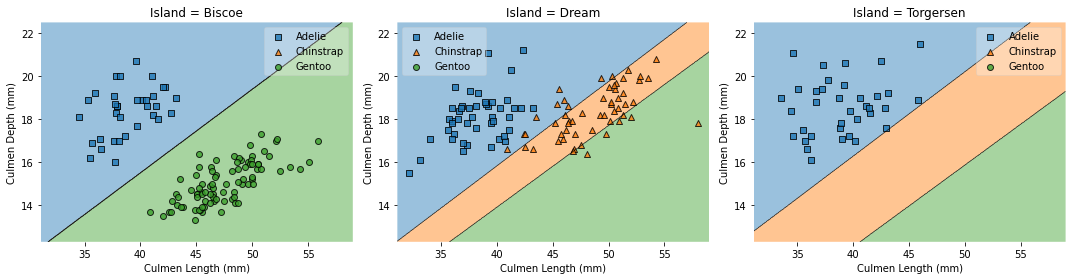

In [34]:
fig, axarr = plt.subplots(1,3, figsize=(15,4), sharey=True)
values = [0, 1, 2]
width = 0.75

for value, ax in zip(values, axarr.flat):
    plot_decision_regions(np.array(X_train0), np.array(y_train), clf=LR,
                          filler_feature_values={2: value},
                          filler_feature_ranges={2: width}, ax = ax)
    ax.set_xlabel('Culmen Length (mm)')
    ax.set_ylabel('Culmen Depth (mm)')
    ax.set_title('Island = {}'.format(keys[2][value]))
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, keys[1].values(), framealpha=0.3, scatterpoints=1)


plt.tight_layout()

From the 2nd plot, we can see that the decision region for Chinstrap penguins is too narrow to capture all of the Chinstrap penguins, hence its higher misclassification rate.

# Decision Tree

The predictor variables Flipper length, body mass and sex were chosen as we wanted to see how predictions would perform with a different set of predictor variables. We also saw from our exploratory analysis that body mass and flipper length could be good variables to use in predictions. 

In [55]:
cols = ["Flipper Length (mm)", "Body Mass (g)","Sex"]

X_train0 = X_train[cols]
X_test0 = X_test[cols]

### Estimating Optimal Model Complexity

In [56]:
best_score=-np.inf
N=30 #largest max depth
scores=np.zeros(N)

for d in range(1,N+1):
    T=tree.DecisionTreeClassifier(max_depth=d)
    scores[d-1]=cross_val_score(T,X_train0,y_train,cv=5).mean()
    if scores[d-1]>best_score:
        best_depth=d
        best_score=scores[d-1]
        
print("Best Depth: " + str(best_depth))
print("Cross Validation Score: " + str(best_score))


Best Depth: 3
Cross Validation Score: 0.7876319758672701


[Text(0.5, 1.0, 'Best Depth: 3')]

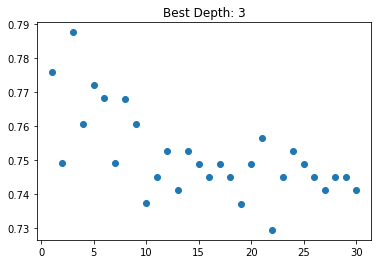

In [57]:
fig,ax=plt.subplots(1)
ax.scatter(np.arange(1,N+1),scores)
ax.set(title="Best Depth: "+str(best_depth))

### Evaluating model performance on test sets

In [58]:
T = tree.DecisionTreeClassifier(max_depth = best_depth)

T.fit(X_train0, y_train)
print("Train accuracy: " + str(T.score(X_train0, y_train)))
print("Test accuracy: " + str(T.score(X_test0, y_test)))

Train accuracy: 0.8185328185328186
Test accuracy: 0.8


### Decision Tree Plot

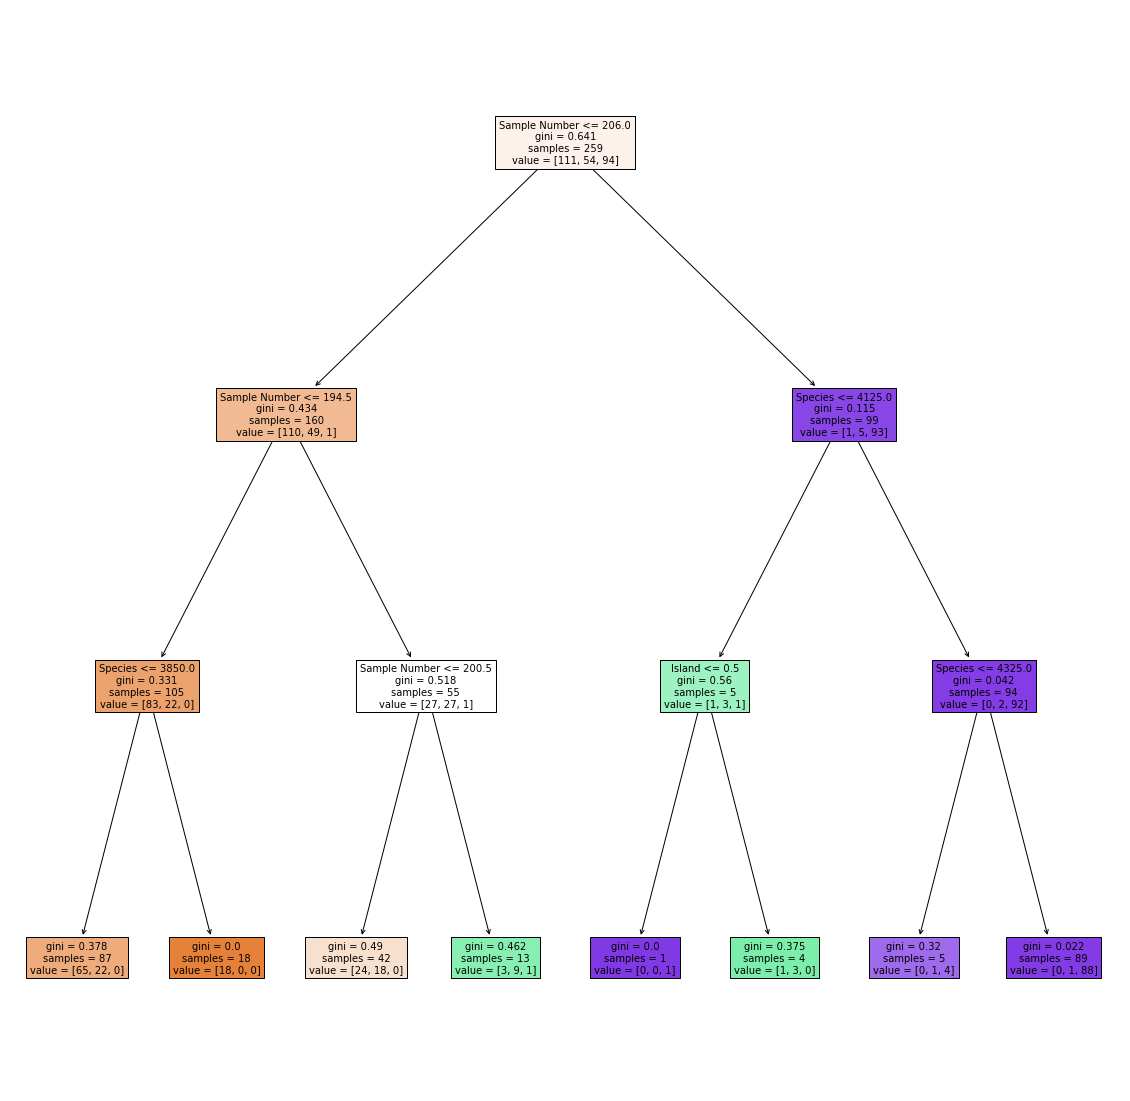

In [59]:
fig, ax = plt.subplots(1, figsize = (20, 20))
p = tree.plot_tree(T, filled = True, feature_names = penguins.columns)

### Confusion Matrix

[[107   4   0]
 [ 40  12   2]
 [  0   1  93]]


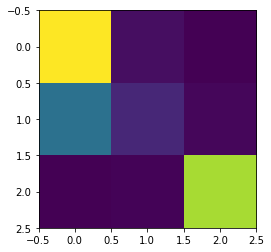

In [60]:
y_train_pred = T.predict(X_train0)
c = confusion_matrix(y_train, y_train_pred)
print(c)
plt.imshow(c)

From the confusion matrix, we can see that the model has misclassified a large number of penguins into the wrong species. 

### Decision regions

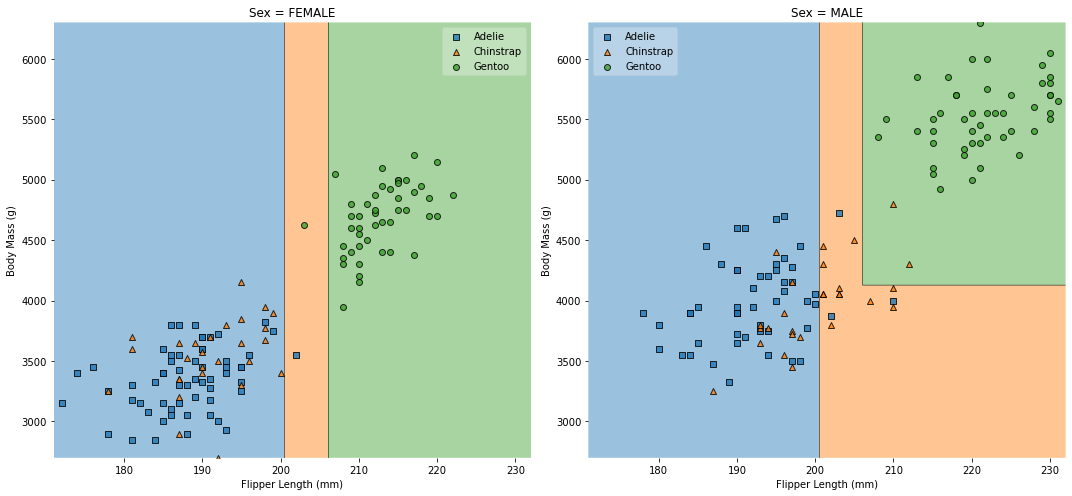

In [61]:
fig, axarr = plt.subplots(1,2, figsize=(15,7), sharey=True)
values = [0, 1]
width = 0.75

for value, ax in zip(values, axarr.flat):
    plot_decision_regions(np.array(X_train0), np.array(y_train), clf=T,
                          filler_feature_values={2: value},
                          filler_feature_ranges={2: width}, ax = ax)
    ax.set_xlabel('Flipper Length (mm)')
    ax.set_ylabel('Body Mass (g)')
    ax.set_title('Sex = {}'.format(keys[0][value]))
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, keys[1].values(), framealpha=0.3, scatterpoints=1)


plt.tight_layout()

## Nearest-neighbor Classifiers

### Feature Selection

In [42]:
knn_cv = KNeighborsClassifier()

X_train, y_train = shuffle(X_train, y_train)
#creating a list of all possible 3 member combinations 
subsets_cols = [i for i in combinations(X_train.columns, 3)]

results = []
for active in subsets_cols: 
    #compute their cross validation score
    CV_score = cross_val_score(knn_cv, X_train[list(active)], y_train, cv=7).mean() 
    #store their performance into a list
    results.append((active, CV_score))

#organize the elements of the list by decending order of their performance
results.sort(key=(lambda tup: tup[1]), reverse = True)
results = pd.DataFrame(results, columns=["Columns", "CV_score"])

#print out our results to find the best combination of traits 
results.head(5)

,Columns,CV_score
0,"(Culmen Length (mm), Culmen Depth (mm), Delta ...",0.984556
1,"(Culmen Length (mm), Culmen Depth (mm), Delta ...",0.972973
2,"(Island, Culmen Length (mm), Culmen Depth (mm))",0.972973
3,"(Culmen Length (mm), Culmen Depth (mm), Sex)",0.969112
4,"(Culmen Length (mm), Delta 15 N (o/oo), Delta ...",0.969112


According to the best CV scores, we select the combination of (Island, Culmen Length (mm), Culmen Depth (mm))

### Model complexity

In [43]:
X_train0 = X_train[["Culmen Length (mm)", "Culmen Depth (mm)", "Island"]]
X_test0 = X_test[["Culmen Length (mm)", "Culmen Depth (mm)", "Island"]]

In [44]:
#select the best parameter for the model 
best_score=-np.inf
N=30 #largest C
scores=np.zeros((4,N))

for cv0 in range(2,6):#loop through all the CV values 
    for c in np.arange(1, 30): #loop through all possible c values 
        new_model = KNeighborsClassifier(n_neighbors = c)
        scores[cv0-2, c-1]=cross_val_score(new_model,X_train0,y_train,cv=cv0).mean()
        if scores[cv0-2, c-1]>best_score:#compute the best socres and the best pair of parameters
            best_C= c
            best_score=scores[cv0-2, c-1]
            best_cv = cv0
      
print("Optimal CV: " + str(best_cv))
print("Optimal C: " + str(best_C))
print("Cross Validation Score: " + str(best_score))

Optimal CV: 4
Optimal C: 2
Cross Validation Score: 0.9807091346153847


We can conclude that the best CV is 4 and that the optimal number of neighbors is 2

[Text(0.5, 1.0, 'Best CV: 4'),
 Text(0.5, 0, 'inverse regularization strength'),
 Text(0, 0.5, 'CV Score')]

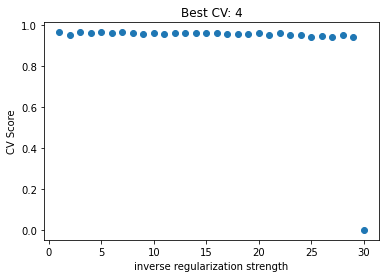

In [45]:
fig,ax=plt.subplots(1)

ax.scatter(np.arange(1,N+1),scores[1,:])
ax.set(title="Best CV: "+str(best_cv), 
       xlabel = "inverse regularization strength", 
       ylabel = "CV Score")

### Evaluating model performance on test sets

In [48]:
KNC = KNeighborsClassifier(n_neighbors = best_C) #test on testing data
KNC.fit(X_train0, y_train)
print(" nearest-neighbor classifiers score: " + str(KNC.score(X_test0, y_test)))

 nearest-neighbor classifiers score: 0.9538461538461539


[[116   0   0]
 [  2  53   0]
 [  0   0  88]]


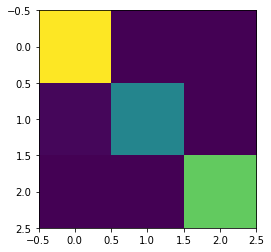

In [47]:
y_train_pred = KNC.predict(X_train0) #confusion matrix
CM = confusion_matrix(y_train, y_train_pred)
print(CM)
plt.imshow(CM)

The confusion matrix confimed the high CV score, showing that our model is quite accuate.

In [49]:
mistakes = X_train[y_train != y_train_pred]
mistakes = np.asarray(mistakes["Sample Number"])
mistake_labels = np.asarray(y_train[y_train != y_train_pred])
mistake_preds = y_train_pred[y_train != y_train_pred]

In [50]:
for i in range(len(mistake_labels)):
    print("Predicted: " + str(keys[1][mistake_preds[i]]) + ", True: " + str(keys[1][mistake_labels[i]])
         + ", Sample number: " + str(mistakes[i]))

Predicted: Adelie, True: Chinstrap, Sample number: 65
Predicted: Adelie, True: Chinstrap, Sample number: 31


There are only two mistakes observed, and they seem to happen between similar species, which indicates that our model is quite reliable. 

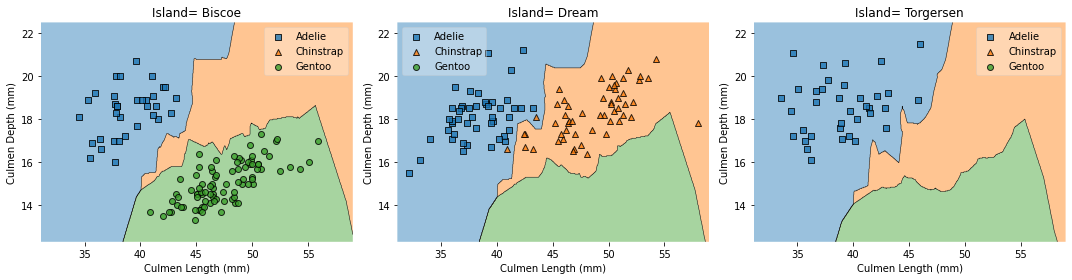

In [51]:
fig, axarr = plt.subplots(1,3, figsize=(15,4), sharey=True)
values = [0, 1, 2]
width = 0.75

for value, ax in zip(values, axarr.flat):
    plot_decision_regions(np.array(X_train0), np.array(y_train), clf=KNC,
                          filler_feature_values={2: value},
                          filler_feature_ranges={2: width}, ax = ax)
    ax.set_xlabel('Culmen Length (mm)')
    ax.set_ylabel('Culmen Depth (mm)')
    ax.set_title('Island= {}'.format(keys[2][value]))
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, keys[1].values(), framealpha=0.3, scatterpoints=1)

plt.tight_layout()

# Discussion

### Best combination of model and measurements

Using Flipper Length (mm), Body Mass (g), and Sex as predictor variables in the decision tree model gave a lower cross validation score than using Culmen Length, Culmen Depth and Island as predictor variables in Multinomial Logistic Regression. 

Using Culmen Length, Culmen Depth and Island as predictor variables in K-Nearest Neighbours gave the highest cross-validation score for both train and test sets among all 3 models. Furthermore, the non-diagonal entries of the confusion matrix for train set were less than or equal to 1. 

Hence, we recommend using K-Nearest Neighbours with n_neighbours = 2 and predictor variables Culmen Length, Culmen Depth and Island to estimate a penguin's species. 

### How the dataset can be improved

The dataset could have a more equal distribution of the three penguins, as there seems to be a very large number of Adelie and Gentoo penguins, but much fewer Chinstrap penguins. We can see from the specific misclassifications that most misclassifications are Chinstrap penguins being classified as other species. Thus, the model could benefit with more information about Chinstrap penguins. 

We also lost some data from removing NaN values, so the dataset could be improved if more penguins had all of their measurements recorded. 

### Limitations

K-nearest neighbours is sensitive to the quality and size of the data. Given a larger dataset, computational cost increases and the accuracy of the model decreases. 

Hence, if we try to extend this model to datasets with bigger number of species, we might not get as high of an accuracy as in this case, where we only use 3 species. 

The model is also restricted to only the Anvers region. 